In [1]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import BaseChronosPipeline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error,
    explained_variance_score,
    mean_absolute_percentage_error
)
#!pip install dtw-python
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
# mudar a estacao
station = "Napier_Aerodrome"

In [4]:
df = pd.read_parquet("dataset_temperature_c_interpolation.parquet")
df.head()

,time,Napier_Aerodrome,Wellington_Aerodrome,Enderby_Island,Mokohinau_Island,Cape_Campbell,Westport_Aerodrome,Mahia_NZMHX,Nelson_Aerodrome,Queenstown_Aerodrome,...,Port_Taharoa,Palmerston_N,Gisborne_Aerodrome,Nugget_Point,Dunedin_Aerodrome,Cape_Reinga,Secretary_Island,Kaitaia_Aerodrome,Takapau_Plains,split
0,01-Apr-1993 00:00,15.0,17.0,7.0,17.0,11.0,17.0,14.0,15.0,8.0,...,15.0,14.0,16.0,10.0,8.0,17.0,14.0,16.5,11.4,True
1,01-Apr-1993 01:00,14.0,17.0,7.0,17.0,11.0,16.0,14.0,15.0,8.0,...,14.0,15.0,15.0,10.0,8.0,16.0,14.0,16.5,11.4,True
2,01-Apr-1993 02:00,14.0,17.0,7.0,17.0,11.0,16.0,15.0,15.0,7.0,...,14.0,14.0,15.0,10.0,8.0,16.0,14.0,16.5,11.4,True
3,01-Apr-1993 03:00,13.0,17.0,7.0,17.0,11.0,16.0,15.0,14.0,6.0,...,15.0,14.0,14.0,10.0,8.0,16.0,14.0,16.5,11.4,True
4,01-Apr-1993 04:00,13.0,17.0,7.0,17.0,11.0,15.0,15.0,14.0,7.0,...,15.0,14.0,14.0,10.0,8.0,16.0,14.0,16.5,11.4,True


In [5]:
train_data = df.query("split == True")[station].values[-1000:]
test_data  = df.query(" split == False ")[station].values[:500]

train_data.shape, test_data.shape

((1000,), (500,))

## Fit context

In [6]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cuda",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)

In [7]:
x_test = np.concatenate([train_data, test_data[:100]])
x_test.shape

(1100,)

In [8]:
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(x_test),
    prediction_length=100,
    quantile_levels=[0.1, 0.5, 0.9],
)

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


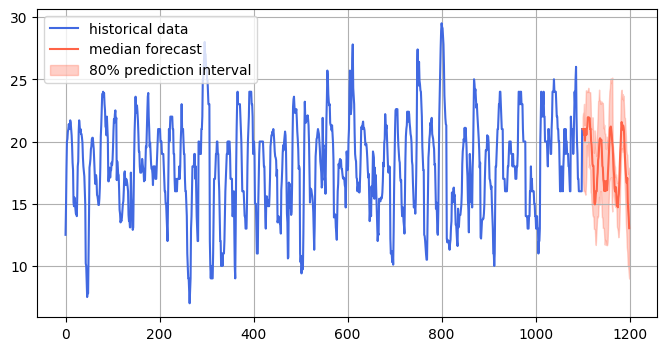

In [9]:
forecast_index = range(len(x_test), len(x_test) + 100)
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

plt.figure(figsize=(8, 4))
plt.plot(x_test, color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [10]:
y_true = test_data[100:200]
y_pred = median

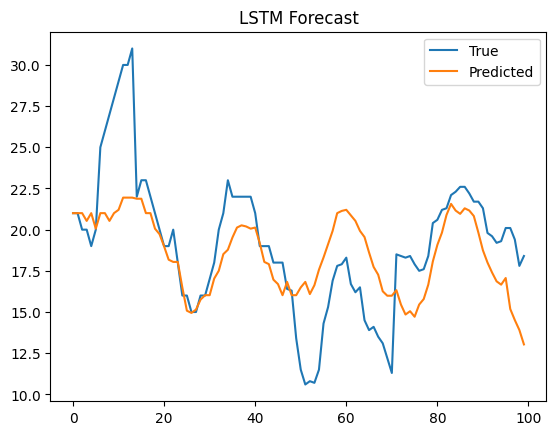

In [11]:
plt.plot(y_true, label="True")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("LSTM Forecast")
plt.show()

In [12]:
#  Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

#  Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)

#  Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# R2 Score
r2 = r2_score(y_true, y_pred)

# Median Absolute Error (MedAE)
medae = median_absolute_error(y_true, y_pred)

# Explained Variance Score
evs = explained_variance_score(y_true, y_pred)


mape = mean_absolute_percentage_error(y_true, y_pred) 

# Exibindo os resultados
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Median Absolute Error (MedAE): {medae:.4f}")
print(f"Explained Variance Score: {evs:.4f}")

Mean Absolute Error (MAE): 2.5878
Mean Squared Error (MSE): 10.9968
Root Mean Squared Error (RMSE): 3.3161
MAPE: 0.1453
R² Score: 0.3534
Median Absolute Error (MedAE): 2.0257
Explained Variance Score: 0.3782


In [13]:
# part II

ini = 0
end = 100
features = train_data.copy()

trues = []
preds = []

for i in range(4):

    features = np.concatenate([features, test_data[ini:end]])

    quantiles, mean = pipeline.predict_quantiles(
        context=torch.tensor(x_test),
        prediction_length=100,
        quantile_levels=[0.1, 0.5, 0.9],
    )
    low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]
    
    
    trues.extend(test_data[ini+100:end+100].tolist())
    preds.extend(median.numpy().tolist())
    
    ini += 100
    end += 100

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


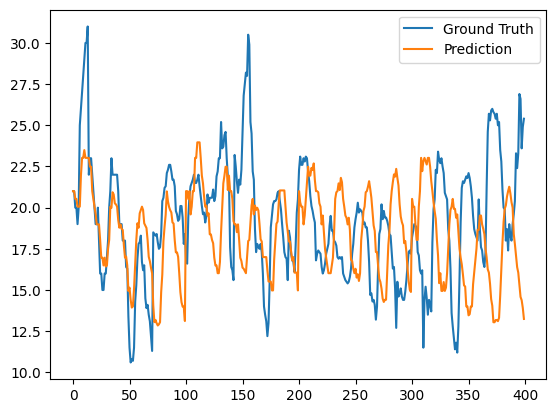

In [14]:
## create dataframe to save results
plt.plot(trues, label="Ground Truth")
plt.plot(preds, label="Prediction")
plt.legend()
plt.show()

In [15]:
df = pd.DataFrame({"y_true": trues, "y_hat": preds})
# salvar as previsoes com o true para calcula a media geral depois
df.to_csv(f"henon_chronos_t5_base_{station}.csv", index=False)
df.head()

,y_true,y_hat
0,21.0,21.002663
1,21.0,21.002663
2,20.0,20.531448
3,20.0,20.531448
4,19.0,20.060236
